# Analysis
This file performs statistical analysis on Mecklenburg, NC residential building permit issuance. The data comes from the cleaned_data.csv file made by the exploring_and_cleaning_building_permit_data.ipynb in this repository. The purpose of the analysis is to determine if residential building permit issuance differed between pre-COVID, COVID, and COVID ignored classes. To understand more about the data cleaning process review exploring_and_cleaning_building_permit_data.ipynb, and to better understand how the COVID classes and date range for data collection are selected review date_range_for_collection.ipynb.

In [1]:
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pmdarima.arima import auto_arima
from scipy.stats import f_oneway
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.statespace.sarimax import SARIMAX

Before getting into the analysis, the COVID classes need to be added to the data.

In [2]:
# Load the data
df = pd.read_csv('data/cleaned_data.csv')
df['Issue Date'] = pd.to_datetime(df['Issue Date']).dt.normalize()
# Add the COVID classes to the data
cov_periods = {'pre-COVID': ['2018-01-01', '2020-06-25'],
               'COVID': ['2020-06-26', '2021-05-14'],
               'COVID ignored': ['2021-05-15', '2022-10-10']}
for k, (s,e) in cov_periods.items():
    df.loc[df['Issue Date'].between(s,e), 'COVID Stage'] = k
df.dtypes

Unnamed: 0                         int64
Permit Number                     object
Permit Type                       object
Construction Cost                float64
Project Name                      object
Owner/Tenant                      object
Issue Date                datetime64[ns]
Occupancy                         object
Number of Stories                float64
Total Fee                        float64
Building Contract Cost            object
Number of Units                  float64
Description of Work               object
COVID Stage                       object
dtype: object

In [3]:
# Aggregate the data to sum the total number of residential units approved for construction by day
agg_df = df.groupby(['Issue Date', 'COVID Stage'])['Number of Units'].sum()
agg_df = agg_df.reset_index()

## Visualizing the Data
Visualizations of the COVID classes and building permit issuance is also important to do before getting into the statistical analysis. It's a way to see how the data is distributed and if any obvious trends exist.

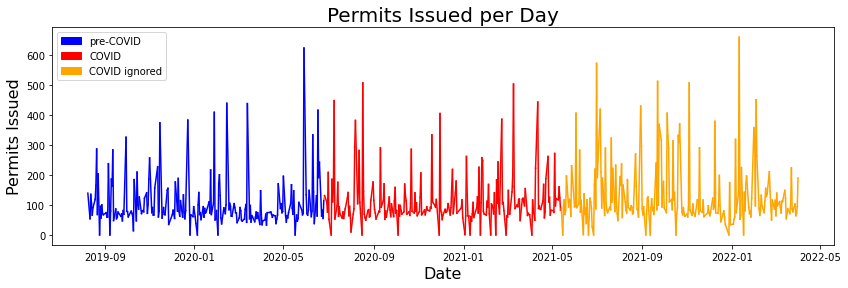

In [4]:
# Making the time series visualization
blue_patch = mpatches.Patch(color='blue', label='pre-COVID')
red_patch = mpatches.Patch(color='red', label='COVID')
orange_patch = mpatches.Patch(color='orange', label='COVID ignored')
plt.figure(figsize=(14,4))
for i in range(1,len(agg_df)):
    s = agg_df.iloc[i-1:i+1]
    if s['COVID Stage'].eq('pre-COVID').all():
        color = 'blue'
    elif s['COVID Stage'].eq('COVID').all():
        color = 'red'
    else:
        color = 'orange'
    plt.plot(s['Issue Date'], s['Number of Units'], c=color)
plt.legend(loc=2, ncol=1, handles=[blue_patch, red_patch, orange_patch])
plt.title('Permits Issued per Day', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Permits Issued', fontsize=16)
plt.savefig('visualizations/permits_issued.jpeg')

The time series does not have any clear trends, increases, seasonality, or change in variance.

It is difficult to see if the distribution of permits issued per day differs between groups visualized as a time series. A boxplot does a much better job at that.

[Text(0.5, 1.0, 'Boxplots of Issued Permits by COVID Stage')]

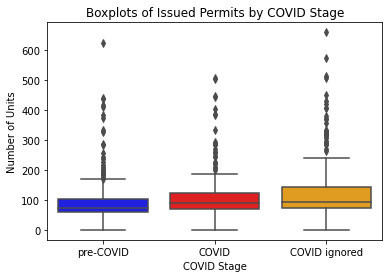

In [5]:
# Making the boxplots
cov_pal = {"pre-COVID": "blue", "COVID": "red", "COVID ignored":"orange"}
box = sns.boxplot(x=agg_df['COVID Stage'], y=agg_df['Number of Units'], palette=cov_pal)
box.set(title='Boxplots of Issued Permits by COVID Stage')

While it appears the average of COVID and COVID ignored is larger than pre-COVID and that COVID ignored's upper range is larger,  the differences are not large enough to claim significance just by looking at them. Statistical analysis is needed.

## ANOVA
One way to test is there is a difference between more than two groups is to perform an ANOVA test. If significance is found, then at least one group population mean is different than the others.

In [6]:
pre_cov = agg_df.loc[agg_df['COVID Stage'] == 'pre-COVID', 'Number of Units']
cov = agg_df.loc[agg_df['COVID Stage'] == 'COVID', 'Number of Units']
cov_ig = agg_df.loc[agg_df['COVID Stage'] == 'COVID ignored', 'Number of Units']
f_oneway(pre_cov, cov, cov_ig)

F_onewayResult(statistic=6.780819630212888, pvalue=0.0012134574259273201)

The p-value is less than 0.05 and the results are significant! Now to determine where that difference lies.

## Paired tests with Bonferroni correction
To choose the correct paired test to use, it's vital to know the population sizes of the group.

In [7]:
print(len(pre_cov), len(cov), len(cov_ig))

225 232 228


The number of observations for each group is large enough to justify using a large-sample Z-test. Null hypotheses will be the paired group means are equal, with the alternative hypotheses being that they are not equal.

In [8]:
print("The p-value required to reject the null hypothesis using the Bonferroni correction is", round(0.05/3, 4))
print("P-value comparing pre-COVID to COVID", ztest(pre_cov, cov)[1])
print("P-value comparing pre-COVID to COVID ignored", ztest(pre_cov, cov_ig)[1])
print("P-value comparing COVID to COVID ignored", ztest(cov_ig, cov)[1])

The p-value required to reject the null hypothesis using the Bonferroni correction is 0.0167
P-value comparing pre-COVID to COVID 0.17514634271731333
P-value comparing pre-COVID to COVID ignored 0.0005551107209669105
P-value comparing COVID to COVID ignored 0.020521236986914687


Bonferroni is a conservative test that leads to less than the desired type I error probability. With that in mind, the large sample Z-tests failed to reject the null hypothesis for pre-COVID and COVID, failed to reject the null hypothesis for COVID and COVID ignored because of the Bonferroni correction, and did reject the null hypothesis for pre-COVID and COVID ignored.

## SARIMAX Model
Significance was found in the ANOVA test as well as the pre-COVID and COVID ignored Z-test. However, both tests assume the data to be independent, and time series data violates that assumption. Another way to approach the evaluation of different COVID groups is to implement a time series model like ARIMA, that can include other factors as well. The SARIMAX model is based off of the ARIMA, but it can also account for seasonality and implement exogenous factors. As mentioned in the discussion under the Permits Issued per Day plot from earlier, the data displayed no clear seasonaility, trends, changing levels, or variance so it can be said that the time series is stationary. Thus, the seasonality aspect of SARIMAX is not needed.

Below are the autocorrelation and partial autocorrelation plots of the data. These help determine how large a p and q to test the SARIMAX model on respectively. The autocorrelation plot is displaying the coefficients of correlation between a time series and its lags, while the partial autocorrelation plot is displaying the coefficients between the series and lags of itself.

C:\Users\Ross\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


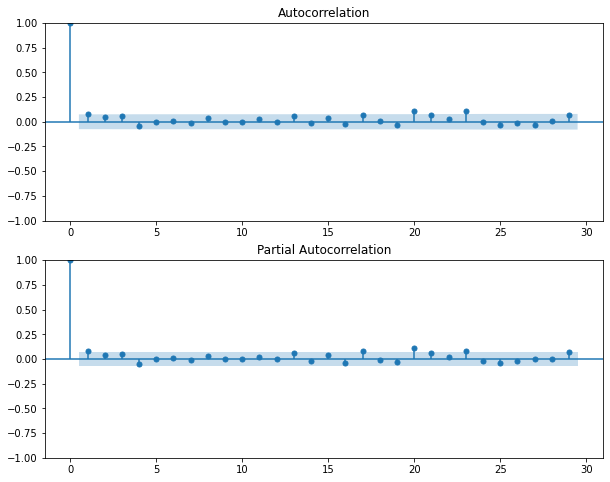

In [9]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plot_acf(agg_df["Number of Units"], ax = plt.gca())
plt.subplot(212)
plot_pacf(agg_df["Number of Units"], ax = plt.gca())
plt.show()

Both plots show significance out to the 23rd lag, so that is the max value that will be tested for both p and q in SARIMAX. The testing will also be stepwise to avoid overfitting. Dummy variables for COVID Stages are made to include the stages as exogenous variable and COVID is the baseline, because it is the group in the middle of the time series.

In [10]:
# One-hot encode the COVID Stage feature
cov_encode = pd.get_dummies(agg_df['COVID Stage'])
cov_encode = cov_encode.drop('COVID', axis=1)
# Stepwise search for best ARIMA model
auto_arima(agg_df["Number of Units"],
           exogenous= cov_encode,
           start_p = 1, max_p = 23, 
           start_q = 1, max_q = 23,
           trace = True, stepwise = True,
           seasonal = False
          ).summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8539.591, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8359.759, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8537.592, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8281.134, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8263.395, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=8240.327, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=8223.164, Time=0.24 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=8214.068, Time=0.39 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=8200.665, Time=0.42 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=8195.931, Time=0.31 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=8191.945, Time=0.23 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=8186.751, Time=0.36 sec
 ARIMA(11,1,0)(0,0,0)[0] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  685
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -4054.646
Date:                Sun, 11 Dec 2022   AIC                           8121.292
Time:                        06:44:54   BIC                           8148.460
Sample:                             0   HQIC                          8131.805
                                - 685                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0635      0.041      1.535      0.125      -0.018       0.144
ar.L2          0.0286      0.035      0.816      0.415      -0.040       0.097
ar.L3          0.0441      0.037      1.195      0.232      -0.028       0.116
ar.L4         -0.0654      0.047     -1.401      0.161      -0.157       0.026
ma.L1         -0.9898      0.006   -163.849      0.000      -1.002      -0.978
sigma2      8203.7252    218.982     37.463      0.000    7774.529    8632.921
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2177.42
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The above model selection determined SARIMAX(4,1,1) as the best fit, so that model will be fit with COVID Stages.

In [11]:
model= SARIMAX(agg_df['Number of Units'], 
               exog=cov_encode,
               order=(4,1,1))
results = model.fit()

C:\Users\Ross\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Number of Units   No. Observations:                  685
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -4054.213
Date:                Sun, 11 Dec 2022   AIC                           8124.426
Time:                        06:47:13   BIC                           8160.650
Sample:                             0   HQIC                          8138.443
                                - 685                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
COVID ignored    19.8043     16.590      1.194      0.233     -12.711      52.319
pre-COVID         5.5783     20.412      0.273      0.785     -34.428      45.585
ar.L1             0.0661      0.042      1.570      0.117      -0.016       0.149
ar.L2             0.0256      0.037      0.692      0.489      -0.047       0.098
ar.L3             0.0434      0.038      1.148      0.251      -0.031       0.117
ar.L4            -0.0632      0.048     -1.323      0.186      -0.157       0.030
ma.L1            -0.9884      0.012    -85.385      0.000      -1.011      -0.966
sigma2         8298.1665    271.318     30.585      0.000    7766.394    8829.939
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2149.25
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             2.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There is no significance found in either the pre-COVID or COVID ignored coefficients. Further the volatility of the model, shown in sigma2's coefficient, is large. It does not appear that significant changes occurred in residential building permit issuance in Mecklenburg, NC between pre-COVID, COVID, and COVID ignored.